## Exercise 1

In [115]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    from urllib.request import urlretrieve

    urlretrieve("https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py", "thinkdsp.py")

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from thinkdsp import decorate, read_wave

In [117]:
from thinkdsp import UncorrelatedGaussianNoise

signal = UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)
noise.ys.shape

(16384,)

In [118]:
from scipy.stats import linregress

loglog = dict(xscale='log', yscale='log')

def plot_bests(ns, bests):
    plt.plot(ns, bests)
    decorate(**loglog)

    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x,y)
    slope = t[0]

    return slope

In [119]:
PI2 = np.pi * 2

def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

In [120]:
ns = 2 ** np.arange(6, 13)

64
78.8 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
282 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
1.14 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
512
6.74 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
33.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
201 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
793 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.2764651651564782

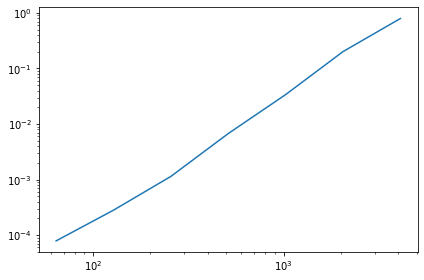

In [121]:
results = []
for N in ns:
    print(N)
    ts = (0.5 + np.arange(N)) / N
    freqs = (0.5 + np.arange(N)) / 2
    ys = noise.ys[:N]
    result = %timeit -r1 -o analyze1(ys, freqs, ts)
    results.append(result)

bests = [result.best for result in results]

plot_bests(ns, bests)

In [122]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

64
48.9 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
233 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
1.13 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
512
5.25 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
21.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
2048
88.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
293 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.109512672314082

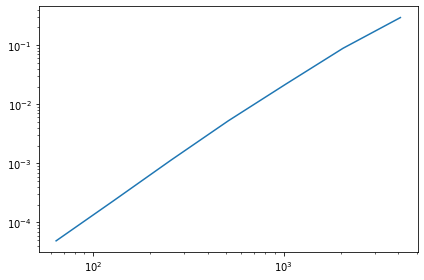

In [123]:

results = []
for N in ns:
    print(N)
    ts = (0.5 + np.arange(N)) / N
    freqs = (0.5 + np.arange(N)) / 2
    ys = noise.ys[:N]
    result = %timeit -r1 -o analyze2(ys, freqs, ts)
    results.append(result)

bests2 = [result.best for result in results]

plot_bests(ns, bests2)

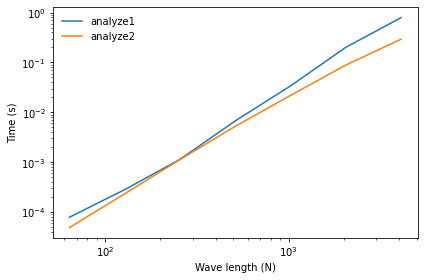

In [124]:
plt.plot(ns, bests, label='analyze1')
plt.plot(ns, bests2, label='analyze2')
decorate(xlabel='Wave length (N)', ylabel='Time (s)', **loglog)

## Exercise 2

In [125]:
from thinkdsp import read_wave

wave = read_wave('Sounds/570372__josefpres__bass-loops-006-short-loop-120-bpm.wav')
wave.make_audio()

In [126]:
segment = wave.segment(start=0, duration=0.5)
segment.normalize()
segment.make_audio()

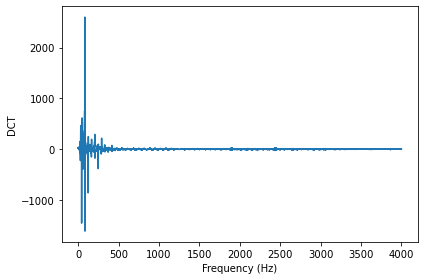

In [127]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
decorate(xlabel='Frequency (Hz)', ylabel='DCT')

In [128]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1

    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

20956	22050	95.03854875283447


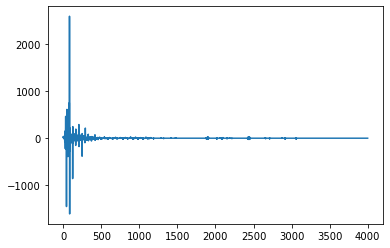

In [129]:
seg_dct = segment.make_dct()
compress(seg_dct, thresh=10)
seg_dct.plot(high=4000)

In [130]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

In [131]:
from thinkdsp import Spectrogram

def make_dct_spectrogram(wave, seg_length):
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length // 2

    # map from time to Spectrum
    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        # the nominal time for this segment is the midpoint
        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

In [132]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.2)

640	1024	62.5
730	1024	71.2890625
710	1024	69.3359375
769	1024	75.09765625
855	1024	83.49609375
939	1024	91.69921875
953	1024	93.06640625
959	1024	93.65234375
968	1024	94.53125
972	1024	94.921875
977	1024	95.41015625
981	1024	95.80078125
978	1024	95.5078125
975	1024	95.21484375
973	1024	95.01953125
983	1024	95.99609375
919	1024	89.74609375
950	1024	92.7734375
983	1024	95.99609375
997	1024	97.36328125
1008	1024	98.4375
716	1024	69.921875
628	1024	61.328125
591	1024	57.71484375
664	1024	64.84375
720	1024	70.3125
768	1024	75.0
851	1024	83.10546875
915	1024	89.35546875
941	1024	91.89453125
975	1024	95.21484375
973	1024	95.01953125
989	1024	96.58203125
985	1024	96.19140625
999	1024	97.55859375
999	1024	97.55859375
1004	1024	98.046875
1014	1024	99.0234375
1011	1024	98.73046875
1010	1024	98.6328125
1012	1024	98.828125
1012	1024	98.828125
778	1024	75.9765625
540	1024	52.734375
527	1024	51.46484375
555	1024	54.19921875
568	1024	55.46875
588	1024	57.421875
647	1024	63.18359375
689	1024	67.285156

In [133]:
wave2 = spectro.make_wave()
wave2.make_audio()

In [134]:
wave.make_audio()

## Exercise 3

In [135]:
def plot_angle(spectrum, thresh=1):
    angles = spectrum.angles
    angles[spectrum.amps < thresh] = np.nan
    plt.plot(spectrum.fs, angles, 'x')
    decorate(xlabel='Frequency (Hz)',
             ylabel='Phase (radian)')

In [146]:
def plot_three(spectrum, thresh=1):
    plt.figure(figsize=(10, 4))
    plt.subplot(1,3,1)
    spectrum.plot()
    plt.subplot(1,3,2)
    plot_angle(spectrum, thresh=thresh)
    plt.subplot(1,3,3)
    wave = spectrum.make_wave()
    wave.unbias()
    wave.normalize()
    wave.segment(duration=0.01).plot()
    display(wave.make_audio())

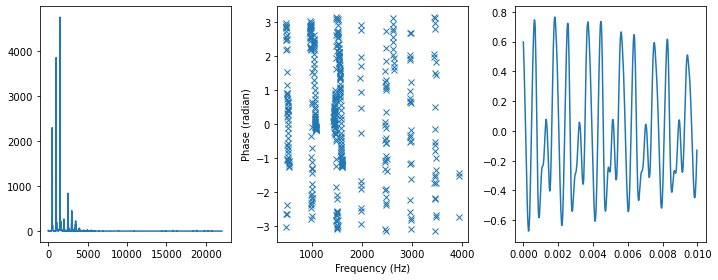

In [149]:
wave = read_wave('Sounds/120994__thirsk__120-oboe.wav')
wave.make_audio()

segment = wave.segment(start=5, duration=1)

spectrum = segment.make_spectrum()
plot_three(spectrum, thresh=50)

In [138]:
def zero_angle(spectrum):
    res = spectrum.copy()
    res.hs = res.amps
    return res

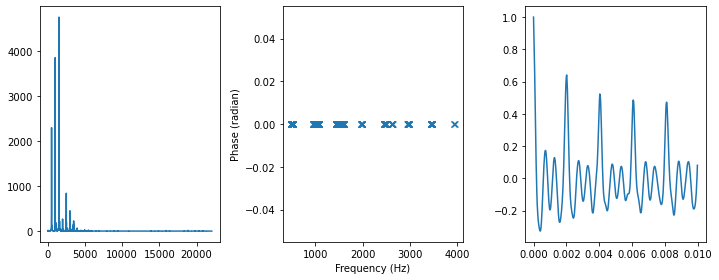

In [147]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

In [140]:
def rotate_angle(spectrum, offset):
    res = spectrum.copy()
    res.hs *= np.exp(1j * offset)
    return res

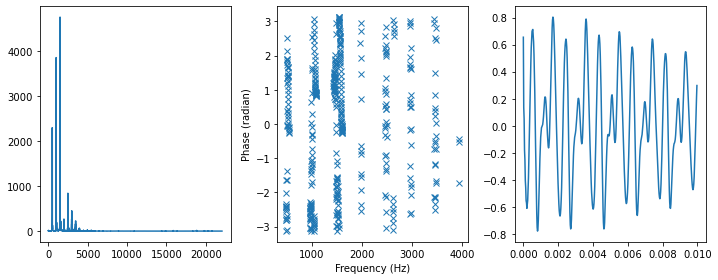

In [152]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

In [142]:
PI2 = np.pi * 2

def random_angle(spectrum):
    res = spectrum.copy()
    angles = np.random.uniform(0, PI2, len(spectrum))
    res.hs *= np.exp(1j * angles)
    return res

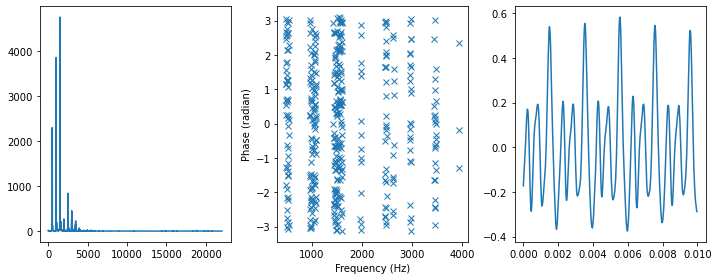

In [151]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)
